In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from os import path
import seaborn as sns
from operator import add
from scipy import sparse, io
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from dotenv import load_dotenv, find_dotenv
from sklearn.preprocessing import LabelEncoder
%matplotlib notebook

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

RAW_DATA_DIR = os.environ.get("RAW_DATA_DIR")

In [3]:
train = pd.read_csv(path.join(RAW_DATA_DIR, 'gender_age_train.csv'))
events = pd.read_csv(path.join(RAW_DATA_DIR, 'events.csv'), parse_dates=['timestamp'])
app_events = pd.read_csv(path.join(RAW_DATA_DIR, 'app_events.csv'))

In [4]:
train = train.sort_values(by='age')
events = events.drop(['longitude', 'latitude'], 1)
app_events['app_id'], map_ids = pd.factorize(app_events['app_id'])

In [5]:
labelled_app_events = (train.merge(events, how='left', on='device_id')
                            .merge(app_events, how='left', on='event_id')
                            )
labelled_app_events = labelled_app_events.fillna(-1)

<IPython.core.display.Javascript object>


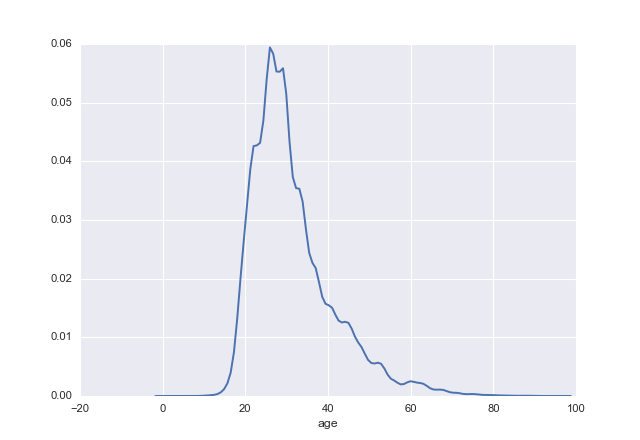

In [17]:
plt.figure()
sns.distplot(train['age'], hist=False)


<IPython.core.display.Javascript object>


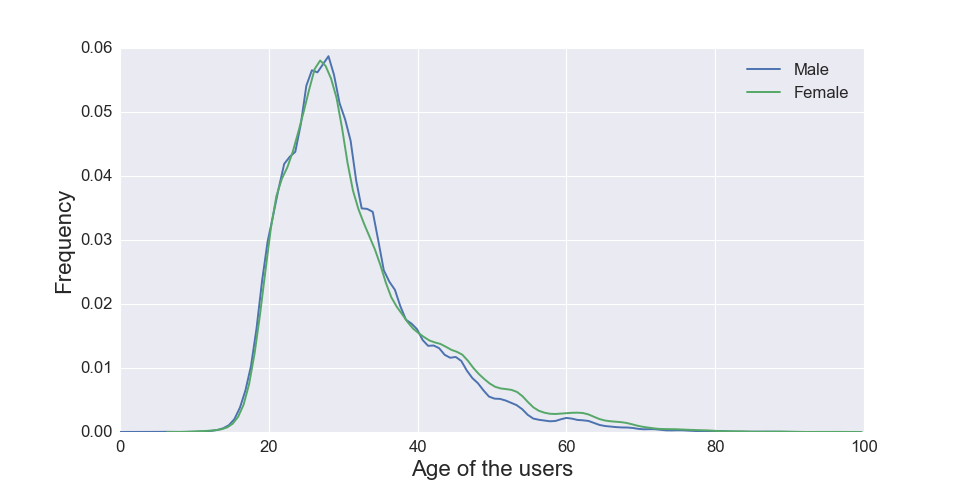

In [10]:
plt.figure(figsize=(12,6))

sns.set(font_scale=1.5)

sns.kdeplot(train.age[train['gender']=="M"], label="Male")
sns.kdeplot(train.age[train['gender']=="F"],  label="Female").axes.set_xlim(0,100)

plt.ylabel('Frequency',{'fontsize': 20})
plt.xlabel('Age of the users',{'fontsize': 20})
plt.xticks(size=15)
plt.yticks(size=15)

plt.show()

<IPython.core.display.Javascript object>


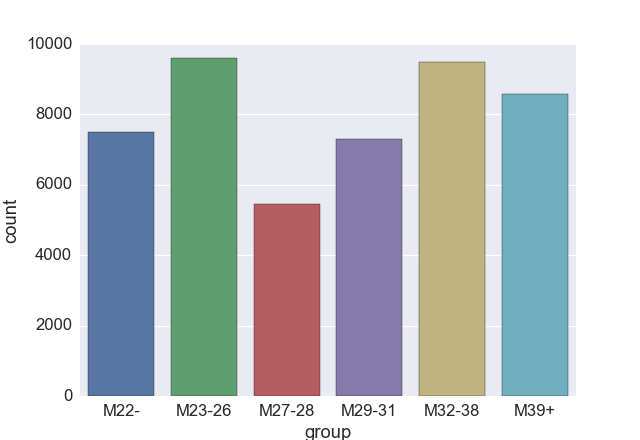

Male age group count


In [12]:
plt.figure()

print("Male age group count")
ax = sns.countplot(x="group", data=train[train['gender']=="M"])

<IPython.core.display.Javascript object>


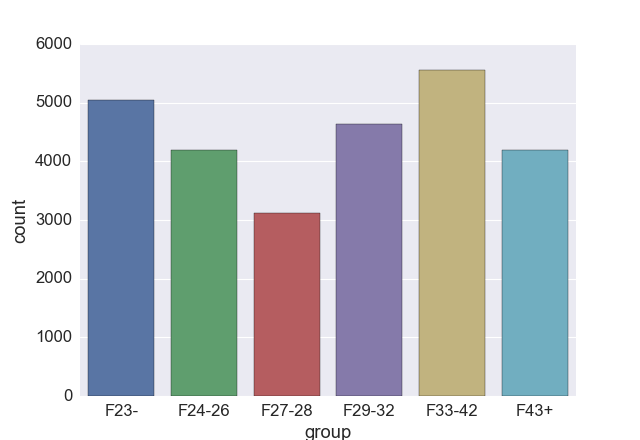

Female age group count


In [13]:
plt.figure()
print("Female age group count")
ax = sns.countplot(x="group", data=train[train['gender']=="F"])

## Day

In [15]:
labelled_app_events.head()

,device_id,gender,age,group,event_id,timestamp,app_id,is_installed,is_active,week_day
0,3553057874282315257,M,1,M22-,-1.0,1969-12-31 23:59:59.999999999,-1.0,-1.0,-1.0,Wednesday
1,5222152119137955379,M,6,M22-,-1.0,1969-12-31 23:59:59.999999999,-1.0,-1.0,-1.0,Wednesday
2,3646841514566479686,M,6,M22-,-1.0,1969-12-31 23:59:59.999999999,-1.0,-1.0,-1.0,Wednesday
3,-8513863533705424532,M,6,M22-,-1.0,1969-12-31 23:59:59.999999999,-1.0,-1.0,-1.0,Wednesday
4,-5323874218045578676,M,6,M22-,-1.0,1969-12-31 23:59:59.999999999,-1.0,-1.0,-1.0,Wednesday


<IPython.core.display.Javascript object>


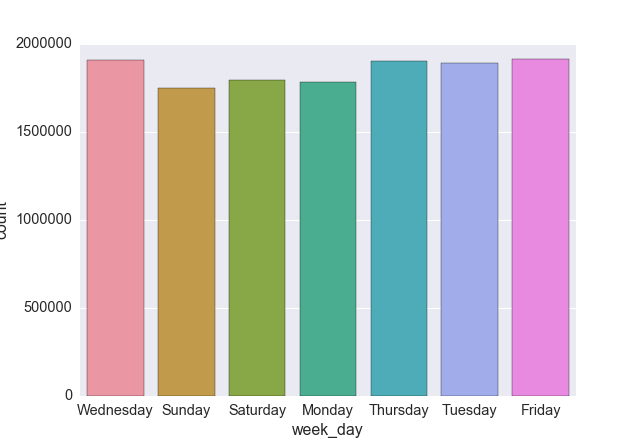

In [18]:
import calendar
sns.set(font_scale=1.3)

labelled_app_events['week_day'] = labelled_app_events.timestamp.apply(lambda x: calendar.day_name[x.weekday()])
plt.figure()
ax = sns.countplot(x="week_day", data=labelled_app_events)

<IPython.core.display.Javascript object>


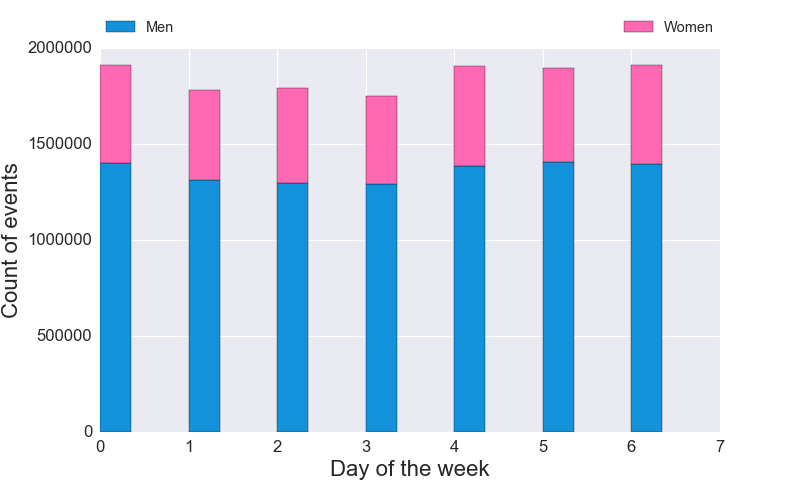

In [24]:
days = np.sort(labelled_app_events['week_day'].unique())
ind = np.arange(len(days))  # the x locations for the groups
width = 0.35

male_days = []
female_days = []
for day in days:
    day_rows = labelled_app_events[ labelled_app_events['week_day'] == day]
    female_days.append(len(day_rows.query('gender == "F"')))
    male_days.append(len(day_rows.query('gender == "M"')))

plt.figure(figsize=(10,6))

p1 = plt.bar(ind, male_days, width, color="#1292db", label='Men')
p2 = plt.bar(ind, female_days, width, color="#ff69b4", bottom=male_days, label='Women')

plt.ylabel('Count of events',{'fontsize': 20})
plt.xlabel('Day of the week',{'fontsize': 20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=20)
plt.setp(ltext[1], fontsize=20)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [25]:
tot = map(add, female_days, male_days)
total = pd.Series(tot, index=range(len(male_days)))
f_users = list(female_days/total)
m_users = list(male_days/total)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "During the whole day the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users, m_users)

During the whole day the percentage of users are: 
- females: ['0.268', '0.264', '0.277', '0.261', '0.272', '0.258', '0.270']
- males: ['0.732', '0.736', '0.723', '0.739', '0.728', '0.742', '0.730']


<IPython.core.display.Javascript object>


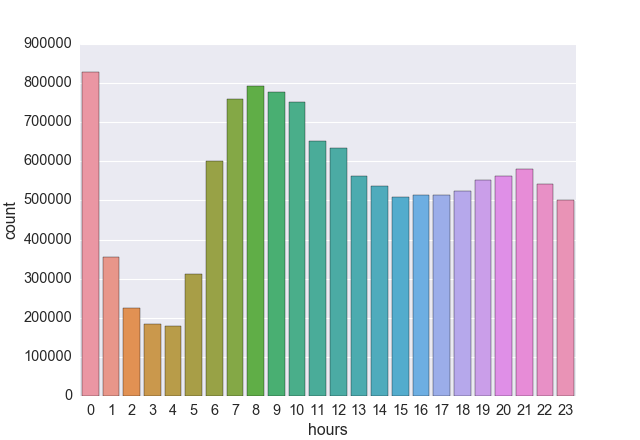

In [26]:
plt.figure()
labelled_app_events['hours'] = labelled_app_events['timestamp'].apply(lambda x: x.hour)
ax = sns.countplot(x='hours', data=labelled_app_events)

<IPython.core.display.Javascript object>


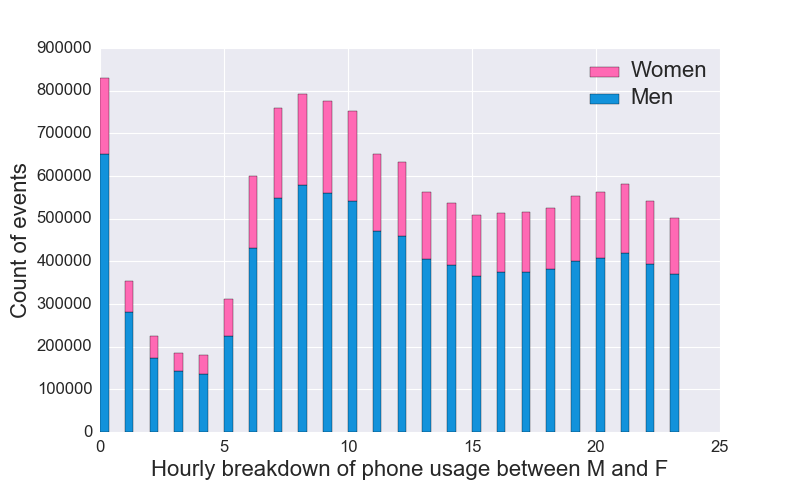

In [28]:
hours = np.sort(labelled_app_events['hours'].unique())
ind = np.arange(len(hours))  # the x locations for the groups
width = 0.35

male_hours = []
female_hours = []
for hour in hours:
    hour_rows = labelled_app_events[ labelled_app_events['hours'] == hour]
    female_hours.append(len(hour_rows.query('gender == "F"')))
    male_hours.append(len(hour_rows.query('gender == "M"')))

plt.figure(figsize=(10,6))
p1 = plt.bar(ind, male_hours, width, color="#1292db")
p2 = plt.bar(ind, female_hours, width, color="#ff69b4", bottom=male_hours)

plt.ylabel('Count of events',{'fontsize': 20})
plt.xlabel('Hourly breakdown of phone usage between M and F',{'fontsize': 20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend((p2[0], p1[0]), ('Women', 'Men'))
ltext = plt.gca().get_legend().get_texts()
plt.setp(ltext[0], fontsize=20)
plt.setp(ltext[1], fontsize=20)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()


In [17]:
tot = map(add, female_hours, male_hours)
total = pd.Series(tot, index=range(len(male_hours)))
f_users = list(female_hours/total)
m_users = list(male_hours/total)

f_users = [ '%.3f' % elem for elem in f_users]
m_users = [ '%.3f' % elem for elem in m_users]

print "During the whole day the percentage of users are: "
print "- females: {}\n- males: {}".format(f_users, m_users)

During the whole day the percentage of users are: 
- females: ['0.215', '0.209', '0.228', '0.226', '0.243', '0.280', '0.282', '0.275', '0.269', '0.279', '0.280', '0.277', '0.274', '0.278', '0.270', '0.283', '0.270', '0.271', '0.271', '0.276', '0.274', '0.278', '0.271', '0.264']
- males: ['0.785', '0.791', '0.772', '0.774', '0.757', '0.720', '0.718', '0.725', '0.731', '0.721', '0.720', '0.723', '0.726', '0.722', '0.730', '0.717', '0.730', '0.729', '0.729', '0.724', '0.726', '0.722', '0.729', '0.736']


In [39]:
age_h_f = (labelled_app_events[labelled_app_events['gender'] == 'F']
           .groupby(['hours', 'group'])
           .agg('count')
           )
age_h_m = (labelled_app_events[labelled_app_events['gender'] == 'M']
           .groupby(['hours', 'group'])
           .agg('count')
           )
age_h = (labelled_app_events
           .groupby(['hours', 'group'])
           .agg('count')
           )


In [40]:
age_h = age_h['device_id'].reset_index()
groups = age_h.pivot(index='hours', columns='group')


<IPython.core.display.Javascript object>


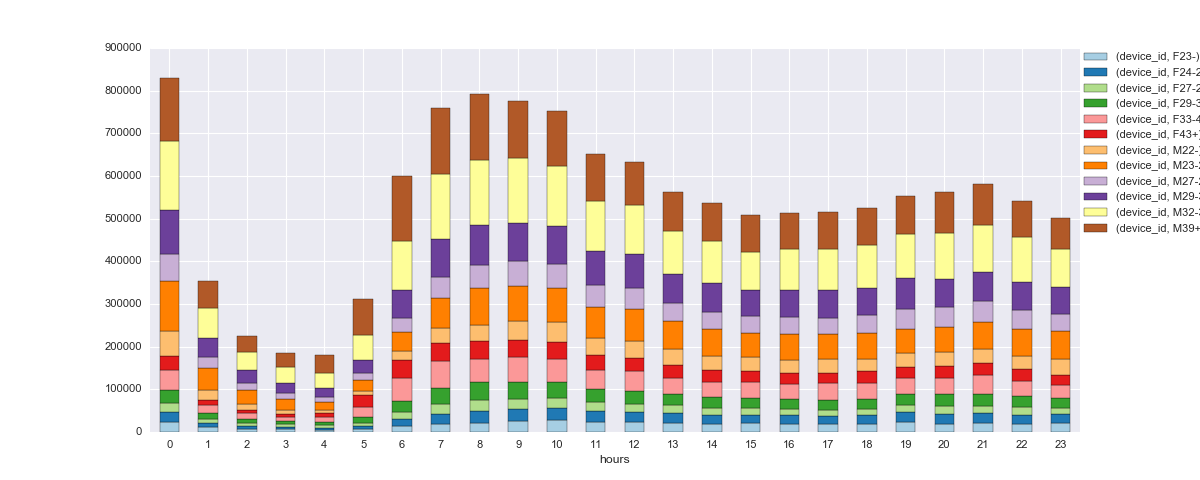

In [59]:
ax = groups.plot(kind='bar', stacked=True, colormap='Paired', rot=0, figsize=(15,6))
plt.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
handles, labels = ax.get_legend_handles_labels()